In [111]:

import networkx as nx
from networkx import DiGraph
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sea
from scipy.stats import spearmanr
from scipy.stats import kruskal
import plotly.io as pio
from IPython.display import display_html


# 1. Introduction

The dataset used in this analysis comes from the who-trusts-whom network of the Bitcoin OTC marketplace, an early peer-to-peer platform where users exchanged Bitcoin. Since participants were anonymous, the platform relied on a reputation system to reduce the risk of fraud. Each member could assign ratings to others on a scale from –10, indicating complete distrust, to +10, indicating complete trust. These ratings produced a weighted, signed, and directed network that records both positive and negative assessments. The dataset, published through the Stanford Large Network Dataset Collection (SNAP), is notable because it was the first large-scale public example of such a network.

This structure provides a valuable foundation for applying social network analysis. Unlike simple binary networks, it captures not only whether a connection exists but also the strength and direction of that connection. As a result, it allows for a detailed examination of how trust and distrust are distributed, how reputational differences influence user positions, and what kinds of structural patterns emerge in an anonymous market. The analysis presented here focuses on centrality measures, group comparisons, and effect sizes to identify which actors hold influence within the network and how trust dynamics shape the overall system.

## 2. Data Preparation

The raw file lists directed ratings from a rater (“source”) to a ratee (“target”) with timestamps and scores from −10 to +10. To avoid counting multiple updates from the same rater, the edge list was first sorted by time and reduced to the most recent observation for each unique source–target pair. From this cleaned edge list, a node-level reputation score was computed as the average of all incoming ratings a node received across its distinct raters. Nodes with no incoming ratings were kept and flagged for labeling.

This average incoming score was then rounded to the nearest integer and mapped to categorical labels: Strong Distrust (−10 to −7), Moderate Distrust (−6 to −3), Mild Distrust (−2 to −1), Neutral (0), Mild Trust (1 to 2), Moderate Trust (3 to 6), and Strong Trust (7 to 10). Nodes with no incoming ratings were labeled No Incoming. These labels are used in the group comparisons and effect-size analyses that follow.

In [3]:
og_df = pd.read_csv("soc-sign-bitcoinotc.csv", sep=',', header=None,
                 names=["source", "target", "rating", "time"])

In [4]:

df = (
    og_df.sort_values("time")
      .drop_duplicates(subset=["source", "target"], keep="last")
)

# Compute average incoming rating for each target node
node_avg = df.groupby("target")["rating"].mean()

def categorize(r):
    if pd.isna(r): 
        return "No Incoming"
    r = round(r)  # round to nearest integer

    if -10 <= r <= -7:
        return "Strong Distrust"
    elif -6 <= r <= -3:
        return "Moderate Distrust"
    elif -2 <= r <= -1:
        return "Mild Distrust"
    elif r == 0:
        return "Neutral"
    elif 1 <= r <= 2:
        return "Mild Trust"
    elif 3 <= r <= 6:
        return "Moderate Trust"
    elif 7 <= r <= 10:
        return "Strong Trust"
    
    else:
        return "Uncategorized"   
    
node_labels = node_avg.apply(categorize)

df = df.merge(node_labels.rename("target_label"), on="target", how="left")

In [5]:
# Build a directed graph
G = nx.from_pandas_edgelist(
    df,
    source="source",
    target="target",
    # edge_attr=["rating"],  # optional edge attributes
    create_using=nx.DiGraph()
)
# nx.set_node_attributes(G, node_labels.to_dict(), "category")
all_nodes = pd.Index(G.nodes())
node_labels_full = node_labels.reindex(all_nodes, fill_value="No Incoming")

# Assign categories
nx.set_node_attributes(G, node_labels_full.to_dict(), "category")

# 3. General Graph

The dataset was represented as a directed graph where nodes are users and edges are trust ratings. To aid interpretation, nodes were color-coded by reputation category: red for distrust, blue/green for trust, purple for neutral, and black for users with no incoming ratings. This scheme makes differences between groups visually clear and highlights patterns in the network structure.

In [6]:

pos = nx.spring_layout(G, seed=4) 

category_colors_all = {
    "Strong Distrust": "#d73027", 
    "Moderate Distrust": "#fc8d59", 
    "Mild Distrust": "#fee08b",    
    "Neutral": "#8211ec",           
    "Mild Trust": "#91bfdb",       
    "Moderate Trust": "#4575b4",    
    "Strong Trust": "#1a9850",
    "No Incoming":  "black"
}

category_color:dict =  category_colors_all.copy()
category_color.pop("No Incoming")

categories = nx.get_node_attributes(G, "category")

node_colors = [
    category_colors_all.get(categories.get(n, "Neutral"), "gray")
    for n in G.nodes
]


### 3.1 Bitcoin OTC Trust Network

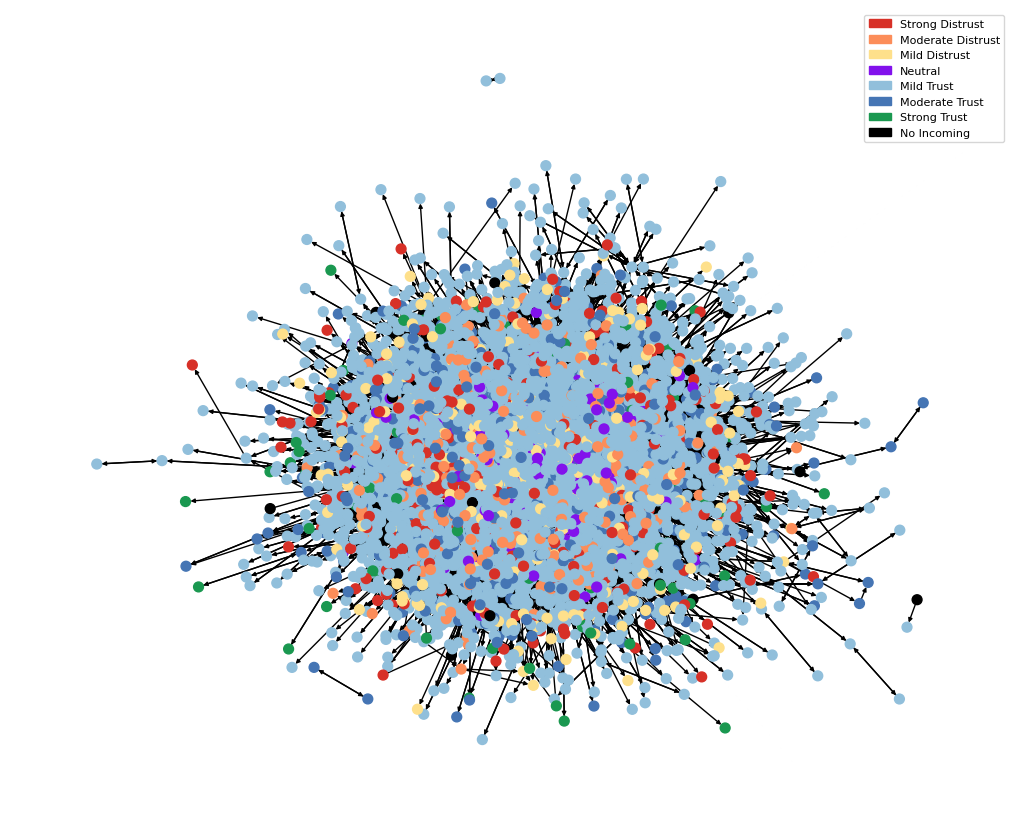

In [7]:

patches = [
    mpatches.Patch(color=color, label=category)
    for category, color in category_colors_all.items()
]

plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=50,
    arrowsize=6
)


plt.legend(handles=patches, loc="best", fontsize=8, frameon=True)
plt.show()



The visualization highlights a dense central core of activity surrounded by smaller peripheral nodes. Most users fall within the main cluster, while a few black nodes with no incoming ratings appear disconnected from the core. Some of these disconnected nodes still issue ratings to others, which means they influence reputations without being part of the main trust structure. Because centrality measures and other network metrics cannot be meaningfully applied to such cases, it is necessary to identify how many of these nodes exist and evaluate whether they should be excluded.

To address this, the network was decomposed into its weakly connected components. A weakly connected component is a subset of nodes where all vertices are connected if the direction of the edges is ignored.

In [8]:
components = list(nx.weakly_connected_components(G))
len(components)
subgraphs = [G.subgraph(c).copy() for c in components]
size = [len(c) for c in components]
size

[5875, 2, 2, 2]


The descompotition identified four distinct components. The largest subgraph contained 5,875 nodes, while the remaining three components were very small, each consisting of only two nodes. These smaller subgraphs represent isolated exchanges that are disconnected from the main trading community. Because the largest component accounts for nearly the entire network, subsequent analysis was performed on this main subgraph to ensure meaningful comparisons and reliable results.

In [9]:
btcTrustGraph:DiGraph = subgraphs[0]

to_remove = [n for n, d in subgraphs[0].nodes(data=True) if d.get("category") == "No Incoming"]

print(f"Removed {len(to_remove)} nodes.")
btcTrustGraph.remove_nodes_from(to_remove)


Removed 22 nodes.


In [10]:
categories2 = nx.get_node_attributes(btcTrustGraph, "category")

node_colors2 = [
    category_colors_all.get(categories.get(n))
    for n in btcTrustGraph.nodes
]


### 3.1.2 Bitcoin OTC Trust Network (Cleaned)

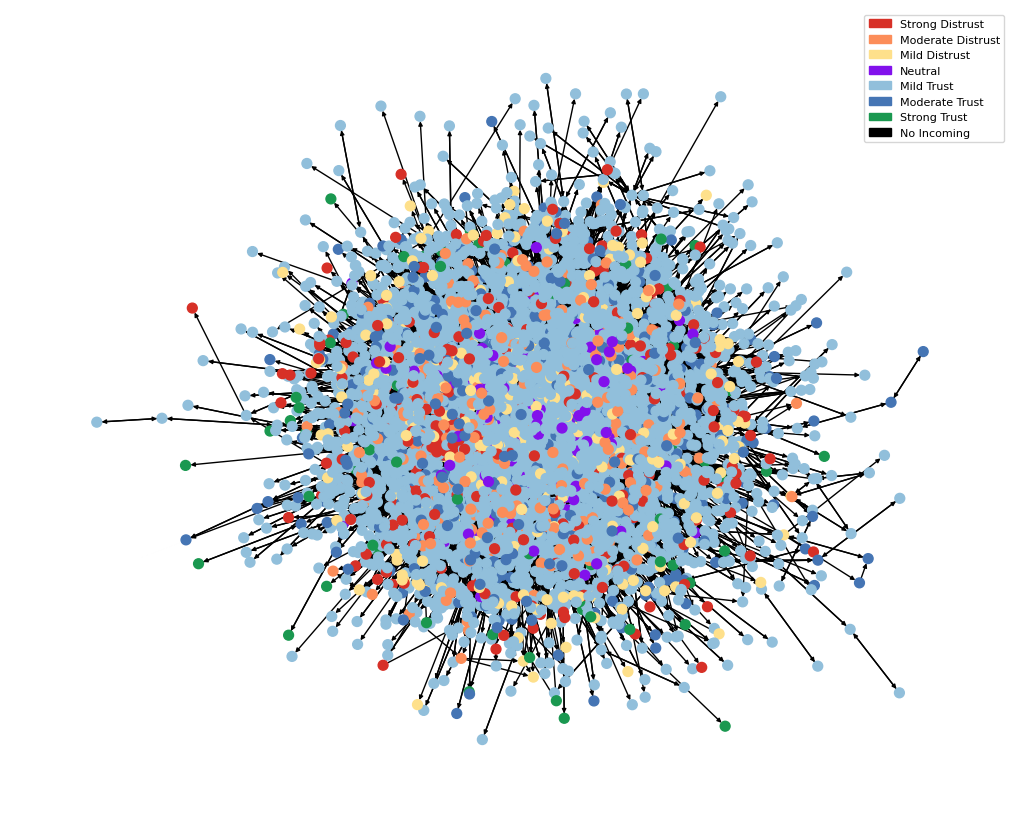

In [11]:
plt.figure(figsize=(10, 8))
nx.draw(
    btcTrustGraph,
    pos,
    node_color=node_colors2,
    with_labels=False,
    node_size=50,
    arrowsize=6
)
plt.legend(handles=patches, loc="best", fontsize=8, frameon=True)
plt.show()

### 3.1.3 Bitcoin OTC Trust Network (3D)

In [12]:

pio.renderers.default = "notebook_connected"

# Step 1: Compute 3D spring layout
pos_3d = nx.spring_layout(btcTrustGraph, dim=3, seed=42)

# Step 2: Build edge trace
edge_x, edge_y, edge_z = [], [], []
for u, v in btcTrustGraph.edges():
    x0, y0, z0 = pos_3d[u]
    x1, y1, z1 = pos_3d[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_z += [z0, z1, None]

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode="lines",
    line=dict(width=1, color="gray"),
    opacity=0.3,
    name="Edges"
)

# Step 3: Build one node trace per category
node_traces = []
for category, color in category_colors_all.items():
    xs, ys, zs, texts = [], [], [], []
    for n in btcTrustGraph.nodes():
        if btcTrustGraph.nodes[n].get("category", "Unknown") == category:
            x, y, z = pos_3d[n]
            xs.append(x)
            ys.append(y)
            zs.append(z)
            texts.append(f"Node {n}, {category}")
    if xs:  # add trace only if category has nodes
        trace = go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode="markers",
            marker=dict(size=3, color=color, opacity=0.8),
            text=texts,
            hoverinfo="text",
            name=category
        )
        node_traces.append(trace)

# Step 4: Combine and plot
fig = go.Figure(data=[edge_trace] + node_traces)
fig.update_layout(
    height=800,
    showlegend=True,
    legend=dict(itemsizing="constant"),
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)
fig.show()


# 3. Graph Metrics and Analysis

To evaluate the Bitcoin OTC trust network, several centrality measures were computed on the largest weakly connected component. These measures capture different aspects of user activity, visibility, and influence.  

- **In-Degree Centrality** reflects how many ratings a user receives, serving as an indicator of visibility and reputation.  
- **Out-Degree Centrality** captures how many ratings a user gives, highlighting engagement in evaluating others.  
- **Betweenness Centrality** identifies users who act as intermediaries, bridging different parts of the network.  
- **Closeness Centrality** shows how quickly a user can reach others, emphasizing efficient access to the community.  
- **In-Closeness Centrality** measures how easily others can reach a user, indicating accessibility to evaluations.  
- **Eigenvector Centrality** highlights users connected to other influential users, emphasizing prestige.  
- **PageRank** provides a robust measure of long-term importance through random walks across the network.  

Together, these metrics offer complementary perspectives on user positions and allow comparisons across trust categories to see whether trusted, distrusted, or neutral users hold central or peripheral roles in the marketplace. To support this comparison, a dataframe will be created that stores each node’s centrality values alongside its assigned reputation category, providing a structured basis for group-level analysis.  


### 3.1 Metrics

In [119]:
in_degree_centrality = nx.in_degree_centrality(btcTrustGraph)
#measure of activity or engagement
out_degree_centrality =  nx.out_degree_centrality(btcTrustGraph)
betweeness_centrality = nx.betweenness_centrality(btcTrustGraph,normalized=True)
closeness_centrality = nx.closeness_centrality(btcTrustGraph)
in_closeness_centrality = nx.closeness_centrality(btcTrustGraph.reverse())


eigen_centrality = nx.eigenvector_centrality(btcTrustGraph.reverse(),max_iter=1000)
page_rank = nx.pagerank(btcTrustGraph,alpha=0.85)




In [110]:

def top_n_degrees(degree_dict: dict, n: int) -> pd.DataFrame:
    df = pd.DataFrame(list(degree_dict.items()), columns=["Node", "Degree"])
    df[f"Degree_(%)"] = (df["Degree"] / df["Degree"].sum())*100

    df = df.sort_values(by="Degree", ascending=False).head(n).reset_index(drop=True).style.hide(axis="index")

    return df

def display_side_by_side(dfs, titles=None):
    html_str = "<div style='display:flex;flex-flow:row nowrap;column-gap:20px'>"
    for df, title in zip(dfs, titles):
        html_str += f"""
        <div style="margin:10px">
            <h4 style="text-align:center">{title}</h4>
            {df.to_html()}
        </div>"""
    html_str += "</div>"

    display_html(html_str, raw=True)


### Comparison of In-Degree and Out-Degree Centrality

In [124]:

in_degree_top = top_n_degrees(in_degree_centrality, 10)
ou_degree_top = top_n_degrees(out_degree_centrality, 10)
betweeness_centrality_top = top_n_degrees(betweeness_centrality, 10)


display_side_by_side(
    [in_degree_top, ou_degree_top,betweeness_centrality_top],
    ["Top 10 In-Degree Centrality", "Top 10 Out-Degree Centrality","Top 10 Betweeness Centrality"]
)

Top 10 In-Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 35 
 0.091251 
 1.502490 
 
 
 2642 
 0.070403 
 1.159225 
 
 
 1810 
 0.053144 
 0.875046 
 
 
 2028 
 0.047334 
 0.779382 
 
 
 905 
 0.045113 
 0.742804 
 
 
 1 
 0.038619 
 0.635885 
 
 
 4172 
 0.037936 
 0.624631 
 
 
 7 
 0.036910 
 0.607749 
 
 
 4197 
 0.034689 
 0.571171 
 
 
 13 
 0.032638 
 0.537408 
 
 
 

 
 
 Top 10 Out-Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 35 
 0.130383 
 2.146816 
 
 
 2642 
 0.069378 
 1.142343 
 
 
 1810 
 0.069036 
 1.136715 
 
 
 2125 
 0.067840 
 1.117020 
 
 
 2028 
 0.050068 
 0.824400 
 
 
 905 
 0.045113 
 0.742804 
 
 
 4172 
 0.045113 
 0.742804 
 
 
 7 
 0.039645 
 0.652767 
 
 
 1 
 0.036740 
 0.604935 
 
 
 3129 
 0.036227 
 0.596494 
 
 
 

 
 
 Top 10 Betweeness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 35 
 0.142670 
 6.520648 
 
 
 2642 
 0.062623 
 2.862151 
 
 
 1810 
 0.049830 
 2.277439 
 
 
 905 
 0.048477 
 2.215593 
 
 
 1 
 0.045249 
 2.068086 
 
 
 4172 
 0.042180 
 1.927814 
 
 
 2125 
 0.041906 
 1.915276 
 
 
 7 
 0.040127 
 1.833988 
 
 
 2028 
 0.038702 
 1.768832 
 
 
 1953 
 0.032548 
 1.487584

### Centrality Comparisons

The **Top 10 In-Degree Centrality** table shows the users with the most incoming connections, while the **Top 10 Out-Degree Centrality** table highlights those who give the most ratings. In both cases, Node **35** leads, followed by **2642** and **1810**, confirming their importance as consistently central users. A core group that includes **2028**, **905**, **4172**, **7**, and **1** also appears in both rankings, showing they are influential whether measured by receiving or giving ratings. The only differences appear at the lower end, where in-degree includes **4197** and **13**, and out-degree includes **2125** and **3129**.  

The **Top 10 Betweenness Centrality** table reinforces this pattern. Node **35** is again the clear leader with 6.52 percent, followed by **2642**, **1810**, **905**, and **1**, all above 2 percent. Other nodes such as **4172**, **2125**, **7**, **2028**, and **1953** also feature, showing they occupy positions that connect different parts of the network. Overall, the same set of users dominates across all measures, with Node **35** emerging as the most central and strategic actor.  


### Comparison of In-Closeness and Out-Closeness Centrality


In [121]:
in_closeness_top = top_n_degrees(in_closeness_centrality, 10)
ou_degree_top = top_n_degrees(closeness_centrality, 10)

display_side_by_side(
    [in_closeness_top, ou_degree_top],
    ["Top 10 In-closeness Centrality", "Top 10 Out-Closeness Centrality"])

Top 10 In-closeness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 905 
 0.427318 
 0.033046 
 
 
 1 
 0.418295 
 0.032348 
 
 
 35 
 0.413735 
 0.031995 
 
 
 13 
 0.405243 
 0.031339 
 
 
 2388 
 0.405158 
 0.031332 
 
 
 3988 
 0.401954 
 0.031084 
 
 
 4291 
 0.401264 
 0.031031 
 
 
 1810 
 0.400494 
 0.030971 
 
 
 2296 
 0.399672 
 0.030908 
 
 
 2642 
 0.397822 
 0.030765 
 
 
 

 
 
 Top 10 Out-Closeness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 905 
 0.339819 
 0.026387 
 
 
 35 
 0.331447 
 0.025737 
 
 
 1 
 0.331216 
 0.025719 
 
 
 2642 
 0.327471 
 0.025428 
 
 
 13 
 0.321015 
 0.024927 
 
 
 2388 
 0.318616 
 0.024741 
 
 
 1810 
 0.317337 
 0.024641 
 
 
 1334 
 0.316648 
 0.024588 
 
 
 353 
 0.315884 
 0.024529 
 
 
 4172 
 0.314131 
 0.024393


The **Top 10 In-Closeness Centrality** table highlights the users who can be most easily reached by others in the network. Node **905** leads with a closeness value of 0.033, followed closely by nodes **1** and **35**. Other key users such as **13**, **2388**, and **1810** also rank high, showing they are well positioned to receive information quickly from across the network.  

The **Top 10 Out-Closeness Centrality** table instead captures users who can most easily reach others. Node **905** again comes first, with nodes **35** and **1** close behind. The overlap with the in-closeness list is strong, with nodes **2642**, **13**, **2388**, and **1810** appearing in both. This shows that many of the same users are central whether considering how quickly they can be reached or how quickly they can spread information.  

The main differences between the two lists are found near the bottom. The in-closeness ranking includes nodes **4291** and **2296**, while the out-closeness ranking features nodes **1334**, **353**, and **4172**. Despite these differences, the consistency of nodes like **905**, **35**, **1**, **2642**, and **1810** across both measures points to a stable core of highly accessible users who are important hubs for communication in the network.  


### Comparison of PageRank and Eigenvector Centrality

In [122]:
page_rank_top = top_n_degrees(page_rank, 10)
eigenvector_top = top_n_degrees(eigen_centrality, 10)

display_side_by_side(
    [page_rank_top, eigenvector_top],
    ["Top 10 PageRank Centrality", "Top 10 Eigenvector Centrality"]
)

Top 10 PageRank Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 35 
 0.015103 
 1.510291 
 
 
 2642 
 0.010839 
 1.083859 
 
 
 1810 
 0.006987 
 0.698680 
 
 
 2028 
 0.006720 
 0.671992 
 
 
 7 
 0.005931 
 0.593147 
 
 
 905 
 0.005381 
 0.538101 
 
 
 1953 
 0.005180 
 0.517982 
 
 
 1 
 0.005039 
 0.503852 
 
 
 4172 
 0.004796 
 0.479595 
 
 
 4197 
 0.004671 
 0.467134 
 
 
 

 
 
 Top 10 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 2642 
 0.192252 
 0.693101 
 
 
 905 
 0.186767 
 0.673328 
 
 
 1810 
 0.167828 
 0.605051 
 
 
 2028 
 0.151619 
 0.546615 
 
 
 35 
 0.151539 
 0.546324 
 
 
 4291 
 0.143162 
 0.516125 
 
 
 4172 
 0.140124 
 0.505174 
 
 
 3988 
 0.133018 
 0.479555 
 
 
 1334 
 0.130413 
 0.470160 
 
 
 1 
 0.126908 
 0.457527



The **Top 10 PageRank Centrality** table highlights users who are influential based on the probability of being visited in a random walk through the network. Node **35** comes first with about 1.51%, followed by Node **2642** at 1.08% and Node **1810** at 0.70%. Other important users include **2028**, **7**, and **905**, showing that these nodes are more likely to be encountered and therefore have higher visibility in the network.  

The **Top 10 Eigenvector Centrality** table instead emphasizes users who are connected to other highly connected users. Here, Node **2642** leads with a score of 0.69, followed closely by **905** at 0.67 and **1810** at 0.61. Node **35**, the top PageRank user, is also important here but ranks slightly lower at 0.55. Additional nodes such as **4291**, **3988**, and **1334** appear in this list, showing influence that comes from being tied to other central actors.  

When comparing both measures, several users stand out across both lists. Nodes **2642**, **905**, **1810**, **2028**, **35**, **4172**, and **1** are consistently central, though their ranking positions shift depending on the metric. The differences are also informative: PageRank highlights **7**, **1953**, and **4197**, while Eigenvector emphasizes **4291**, **3988**, and **1334**. This suggests that while both measures capture centrality, PageRank favors nodes with many incoming paths, whereas Eigenvector highlights those embedded within clusters of other influential users.  


In [ ]:

metrics_rows = []
for node, node_data in btcTrustGraph.nodes(data=True):
    row = {
        "node":node,
        "category":node_data.get("category"),
        "in_degree_centrality": in_degree_centrality.get(node,0),
        "out_degree_centrality": out_degree_centrality.get(node,0) ,       
        "betweeness_centrality": betweeness_centrality.get(node,0) ,
        "closeness_centrality": closeness_centrality.get(node,0),
        "eigenvector_centrality": eigen_centrality.get(node,0) ,
        "page_rank_centrality": page_rank.get(node,0),
        "in_closeness_centrality": in_closeness_centrality.get(node,0) 


    }
    metrics_rows.append(row)
        
                  
metrics_df = pd.DataFrame(metrics_rows)

for metric in ["in_degree_centrality","out_degree_centrality","betweeness_centrality","closeness_centrality",
               "in_closeness_centrality","eigenvector_centrality"]:


    metrics_df[f"{metric}_normalized"] = (
        metrics_df[metric] / metrics_df[metric].sum()
    )



## 3.2 Analysis

In [ ]:

def summarize_centrality(metrics_df, metric_col):

    grouped = metrics_df.groupby("category")[metric_col]
    
    total_by_cat = grouped.sum()
    count_by_cat = grouped.count()
    normalized_by_cat = total_by_cat / count_by_cat
    median_by_cat = grouped.median()
    iqr_by_cat = grouped.quantile(0.75) - grouped.quantile(0.25)
    
    summary = pd.DataFrame({
        f"total_{metric_col}": total_by_cat,
        "count": count_by_cat,
        f"avg_{metric_col}_per_node": normalized_by_cat,
        f"median_{metric_col}": median_by_cat,
        f"iqr_{metric_col}": iqr_by_cat
    })
    
    return summary.sort_values(f"avg_{metric_col}_per_node", ascending=False)


def render_eda_plots(df, metric, category_col="category",
                     category_colors=None, log_scale=False):
    categories = list(category_colors.keys()) if category_colors else df[category_col].unique()

    fig = plt.figure(figsize=(14, 11))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 2])

    ax_pdf  = fig.add_subplot(gs[0, 0])
    ax_ecdf = fig.add_subplot(gs[0, 1])
    ax_box  = fig.add_subplot(gs[1, :])
    sea.set_style("darkgrid")  # dark background + grid

    sea.kdeplot(
        data=df, x=metric, hue=category_col,
        hue_order=categories, palette=category_colors,
        fill=False, alpha=1, common_norm=False, ax=ax_pdf
    )
    ax_pdf.set_title(f"PDF of {metric}")
    ax_pdf.set_xlabel(metric); ax_pdf.set_ylabel("Density")
    if log_scale: ax_pdf.set_xscale("log")

    sea.ecdfplot(
        data=df, x=metric, hue=category_col,
        hue_order=categories, palette=category_colors, ax=ax_ecdf
    )
    ax_ecdf.set_title(f"ECDF of {metric}")
    ax_ecdf.set_xlabel(metric); ax_ecdf.set_ylabel("Cumulative Probability")
    if log_scale: ax_ecdf.set_xscale("log")

    sea.boxplot(
        data=df, y=category_col, x=metric,
        order=categories, hue=category_col,
        palette=category_colors, dodge=False, legend=False, ax=ax_box
    )
    ax_box.set_title(f"Boxplot of {metric} by {category_col}")
    ax_box.set_xlabel(metric); ax_box.set_ylabel(category_col)
    if log_scale: ax_box.set_xscale("log")

    plt.tight_layout()
    plt.show()


order = [
    "Strong Distrust",
    "Moderate Distrust",
    "Mild Distrust",
    "Neutral",
    "Mild Trust",
    "Moderate Trust",
    "Strong Trust"]

### In Degree Centrality

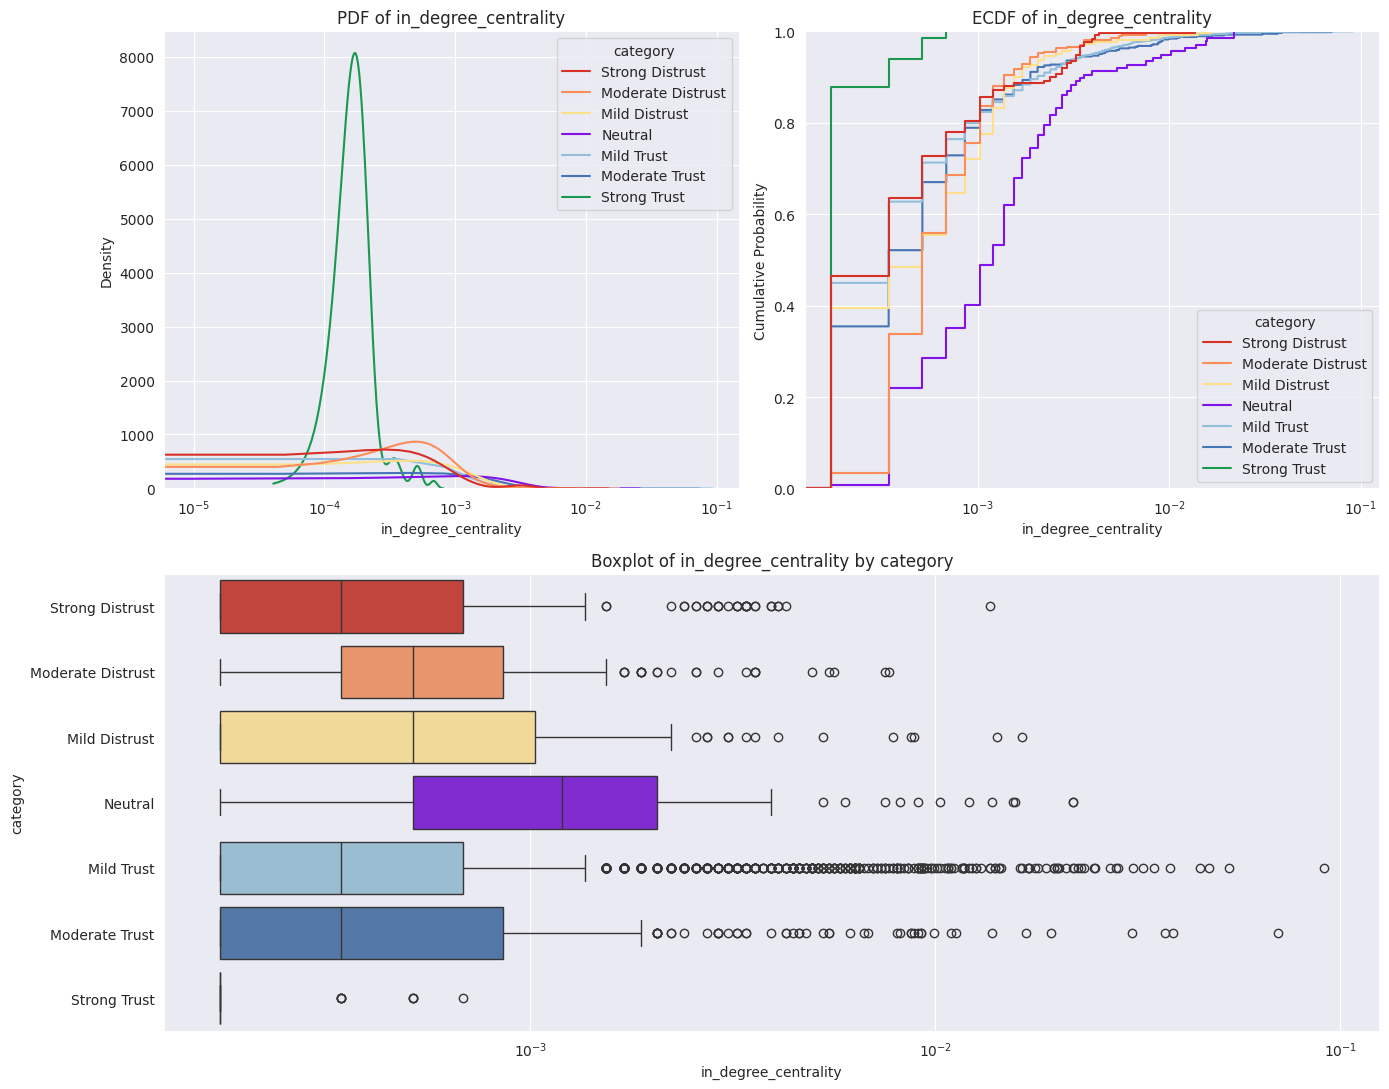

In [47]:
render_eda_plots(metrics_df, "in_degree_centrality", category_colors=category_color, log_scale=True)


In [71]:
summarize_centrality(metrics_df,"in_degree_centrality_normalized")

total_in_degree_centrality_normalized  count  \
category                                                          
Neutral                                         0.049323    137   
Moderate Trust                                  0.115275    564   
Mild Trust                                      0.727695   4309   
Mild Distrust                                   0.038378    258   
Moderate Distrust                               0.036803    270   
Strong Distrust                                 0.030303    249   
Strong Trust                                    0.002223     66   

                   avg_in_degree_centrality_normalized_per_node  \
category                                                          
Neutral                                                0.000360   
Moderate Trust                                         0.000204   
Mild Trust                                             0.000169   
Mild Distrust                                          0.000149   
Moderate Distrust                                      0.000136   
Strong Distrust                                        0.000122   
Strong Trust                                           0.000034   

                   median_in_degree_centrality_normalized  \
category                                                    
Neutral                                          0.000197   
Moderate Trust                                   0.000056   
Mild Trust                                       0.000056   
Mild Distrust                                    0.000084   
Moderate Distrust                                0.000084   
Strong Distrust                                  0.000056   
Strong Trust                                     0.000028   

                   iqr_in_degree_centrality_normalized  
category                                                
Neutral                                       0.000253  
Moderate Trust                                0.000113  
Mild Trust                                    0.000084  
Mild Distrust                                 0.000141  
Moderate Distrust                             0.000084  
Strong Distrust                               0.000084  
Strong Trust                                  0.000000

The plots show that most users in the network receive very few ratings. This is visible in the sharp peaks near zero in the distributions. Strong Trust users often appear at the very bottom, which means that even though they are highly trusted, they are rarely rated. Neutral users, on the other hand, stand out. As shown in the table, they have the highest averages and medians, making them the most consistently connected group, even without strong positive or negative reputations. The cumulative plots also highlight that neutral and distrusted users are more likely to reach higher values, suggesting they attract more ratings overall.

The boxplot reinforces this pattern. Distrusted users usually receive more ratings than trusted ones, with higher medians across categories, and this is also evident in the table. Neutral users appear especially well connected compared to other groups. By contrast, Mild and Moderate Trust users are pulled down because most of them receive almost no ratings. Strong Trust is the lowest category overall, in both the plots and the table, showing that strong positive reputations are rare and not linked to greater visibility. Taken together, the plots and the table make it clear that having a good reputation does not necessarily mean being more central. In many cases, neutral or distrusted users end up more visible than trusted ones.

### Out Degree Centrality

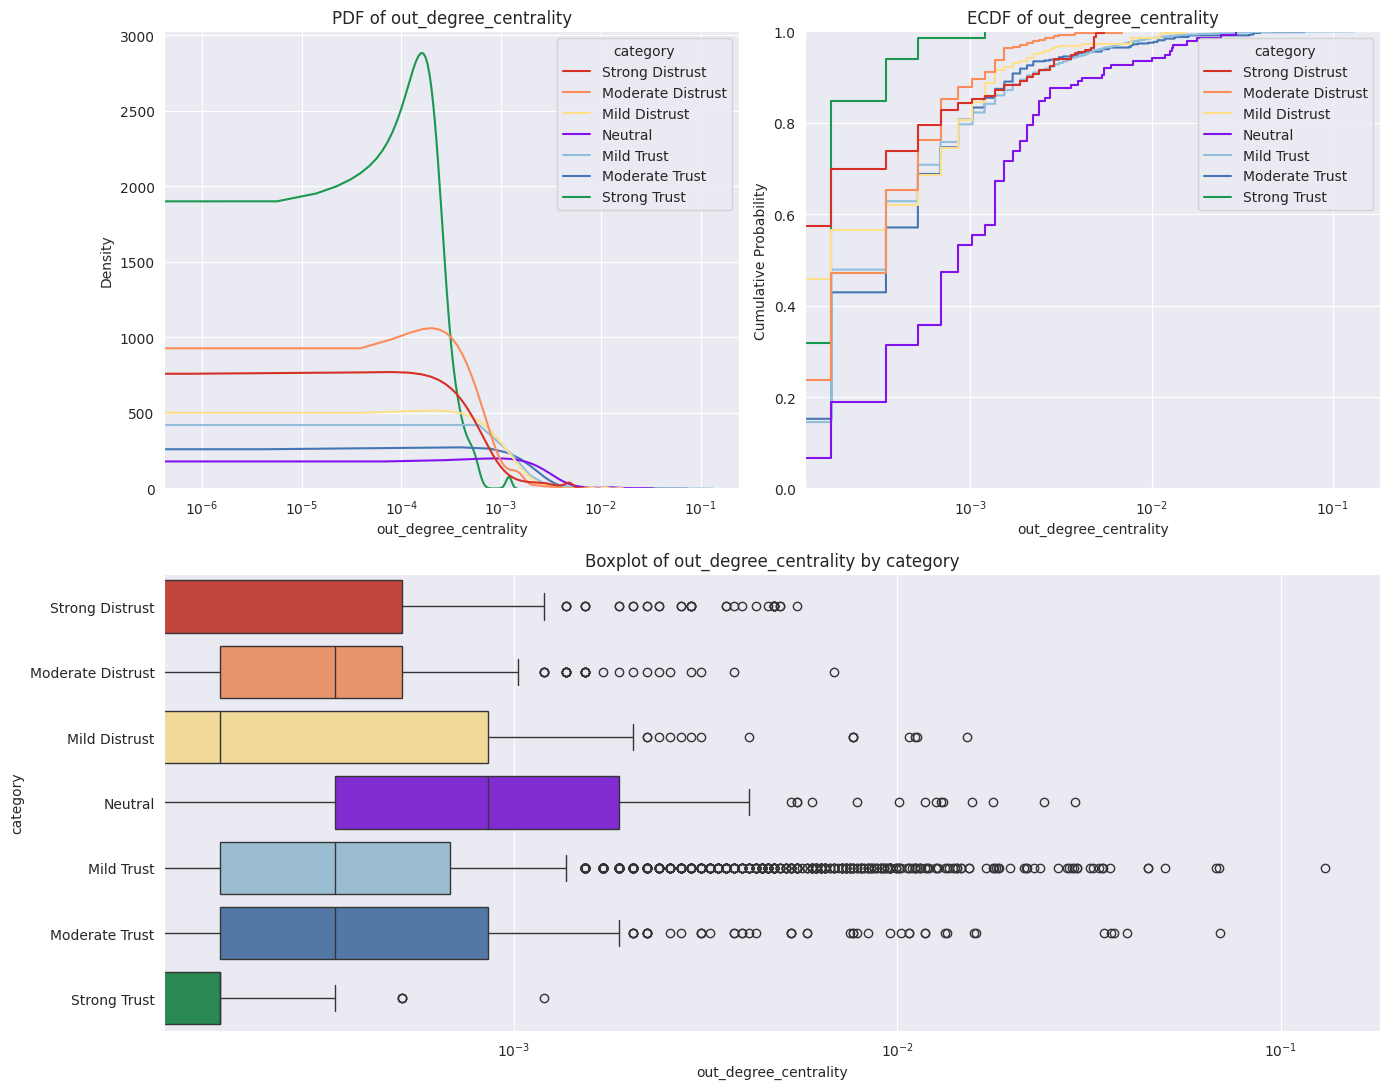

In [59]:
render_eda_plots(metrics_df, "out_degree_centrality", category_colors=category_color, log_scale=True)

In [126]:
summarize_centrality(metrics_df,"out_degree_centrality_normalized")

total_out_degree_centrality_normalized  count  \
category                                                           
Neutral                                          0.049436    137   
Moderate Trust                                   0.114319    564   
Mild Trust                                       0.761008   4309   
Mild Distrust                                    0.029853    258   
Strong Distrust                                  0.023044    249   
Moderate Distrust                                0.020568    270   
Strong Trust                                     0.001773     66   

                   avg_out_degree_centrality_normalized_per_node  \
category                                                           
Neutral                                                 0.000361   
Moderate Trust                                          0.000203   
Mild Trust                                              0.000177   
Mild Distrust                                           0.000116   
Strong Distrust                                         0.000093   
Moderate Distrust                                       0.000076   
Strong Trust                                            0.000027   

                   median_out_degree_centrality_normalized  \
category                                                     
Neutral                                           0.000141   
Moderate Trust                                    0.000056   
Mild Trust                                        0.000056   
Mild Distrust                                     0.000028   
Strong Distrust                                   0.000000   
Moderate Distrust                                 0.000056   
Strong Trust                                      0.000028   

                   iqr_out_degree_centrality_normalized  
category                                                 
Neutral                                        0.000253  
Moderate Trust                                 0.000113  
Mild Trust                                     0.000084  
Mild Distrust                                  0.000141  
Strong Distrust                                0.000084  
Moderate Distrust                              0.000056  
Strong Trust                                   0.000028

The analysis of out-degree centrality shows that neutral, mild trust, and moderate trust users are the most engaged in rating others. Neutral users stand out because, on average, each person in this group rates more than any other category. Mild trust users, however, contribute the most in total because there are so many of them, even though individual activity is lower. Moderate trust falls in between, with moderate levels of engagement across the group.

Strong trust users are the least engaged, rarely rating others and showing almost no variation. Distrust categories are lower overall. Mild and strong distrust show more spread, with most users rating very little but a few being noticeably more active. Moderate distrust, by contrast, is both low and consistent.

### Betweeness Centrality

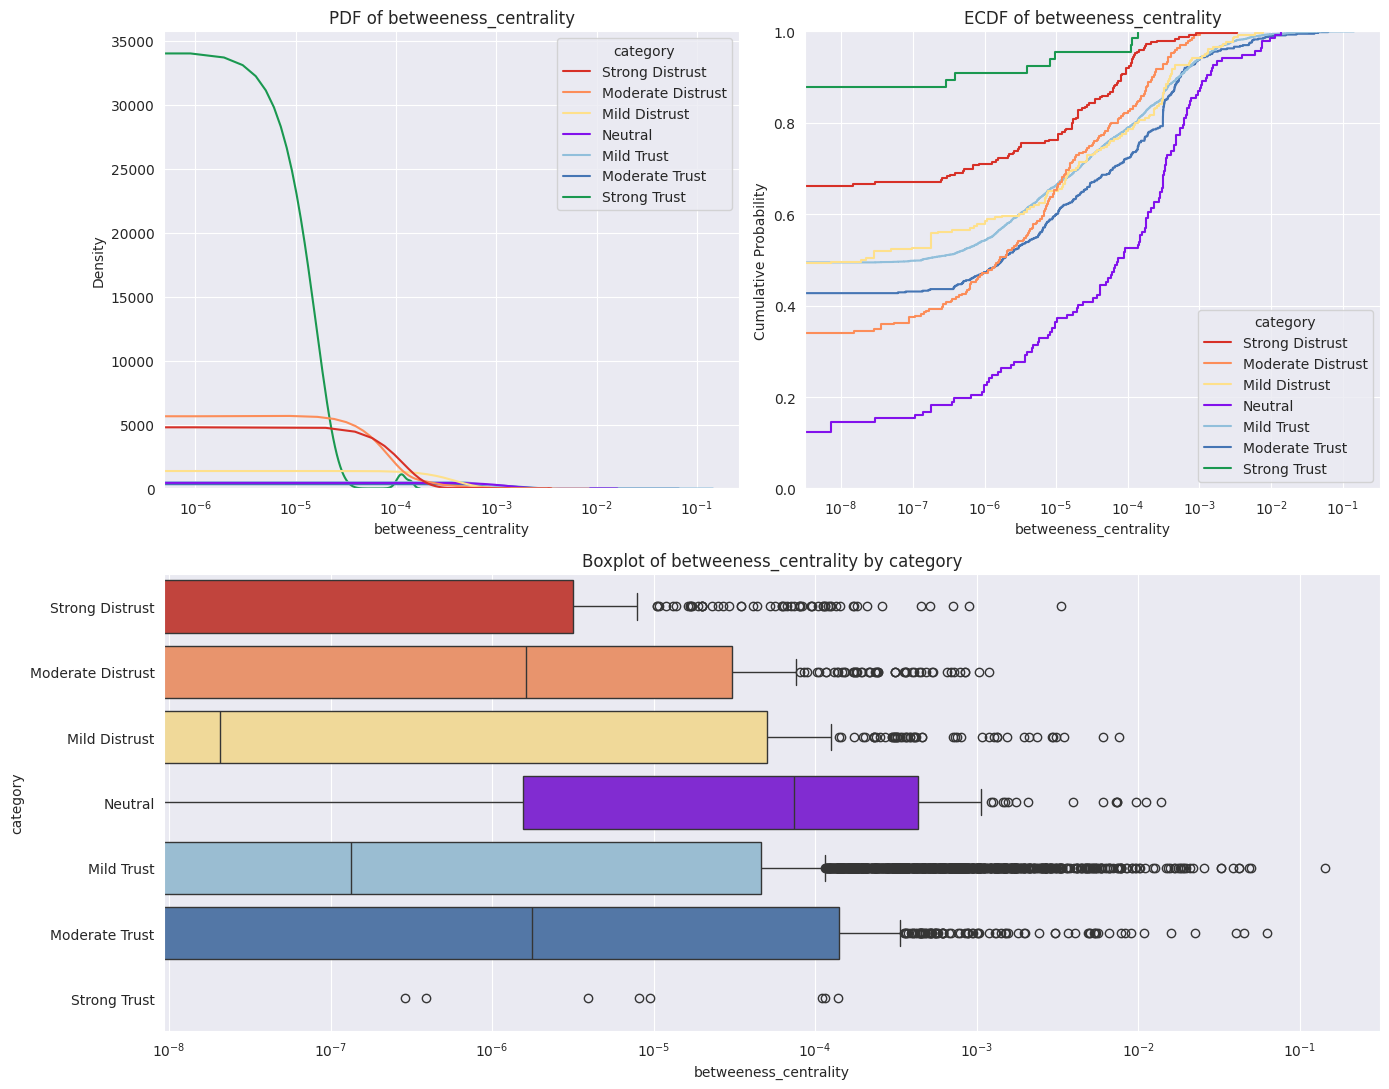

In [60]:
render_eda_plots(metrics_df, "betweeness_centrality", category_colors=category_color, log_scale=True)


In [127]:
summarize_centrality(metrics_df,"betweeness_centrality_normalized")

total_betweeness_centrality_normalized  count  \
category                                                           
Neutral                                          0.045845    137   
Moderate Trust                                   0.158824    564   
Mild Trust                                       0.756908   4309   
Mild Distrust                                    0.025214    258   
Moderate Distrust                                0.008572    270   
Strong Distrust                                  0.004460    249   
Strong Trust                                     0.000177     66   

                   avg_betweeness_centrality_normalized_per_node  \
category                                                           
Neutral                                                 0.000335   
Moderate Trust                                          0.000282   
Mild Trust                                              0.000176   
Mild Distrust                                           0.000098   
Moderate Distrust                                       0.000032   
Strong Distrust                                         0.000018   
Strong Trust                                            0.000003   

                   median_betweeness_centrality_normalized  \
category                                                     
Neutral                                       3.358720e-05   
Moderate Trust                                8.120313e-07   
Mild Trust                                    6.098796e-08   
Mild Distrust                                 9.380972e-09   
Moderate Distrust                             7.403050e-07   
Strong Distrust                               0.000000e+00   
Strong Trust                                  0.000000e+00   

                   iqr_betweeness_centrality_normalized  
category                                                 
Neutral                                        0.000198  
Moderate Trust                                 0.000064  
Mild Trust                                     0.000021  
Mild Distrust                                  0.000023  
Moderate Distrust                              0.000014  
Strong Distrust                                0.000001  
Strong Trust                                   0.000000

The probability density plot shows that most users have very small betweenness centrality, meaning they rarely act as bridges in the network. Among the groups, Neutral users stand out most clearly. Their density curve stretches further than any other, reflecting the fact that they include the largest share of individuals who take on bridging roles. Moderate Trust users follow, also showing a notable presence of connectors, while Mild Trust contributes in total numbers because of its large size, even though individual values are smaller.  

The boxplot confirms this pattern. Neutral users have the highest median betweenness by a wide margin, making them the group most consistently positioned to link different parts of the network. Moderate Trust ranks just behind, and Mild Trust adds breadth through group size rather than individual strength. By contrast, Mild Distrust and Strong Distrust remain low overall, and Strong Trust users play virtually no bridging role at all.  


### Out Closeness Centrality

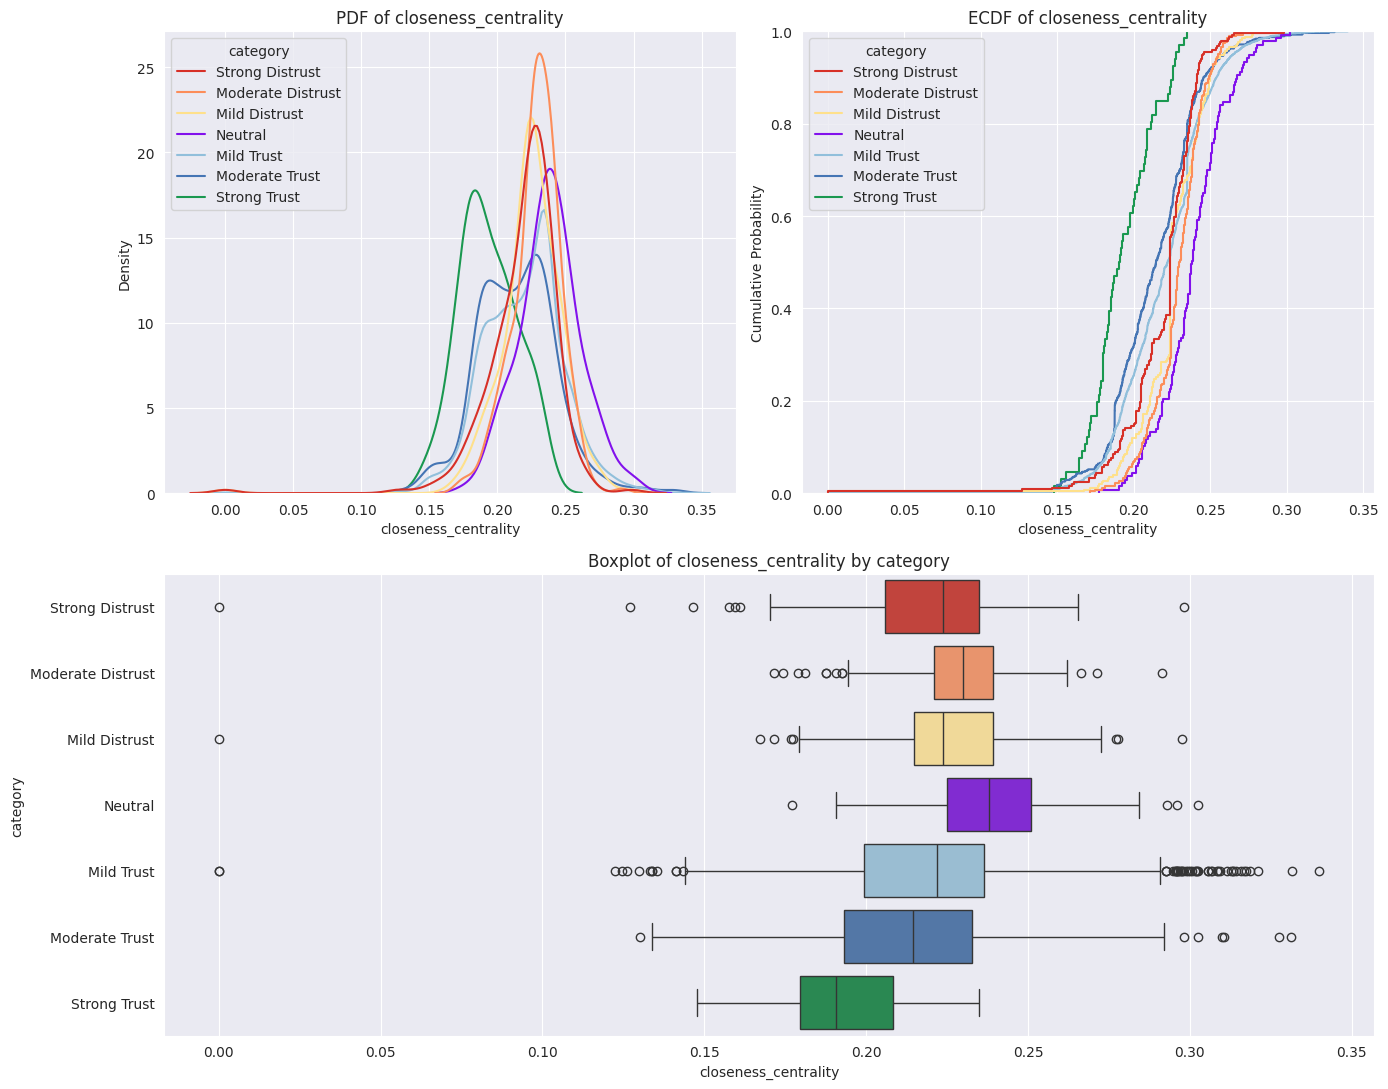

In [61]:
render_eda_plots(metrics_df, "closeness_centrality", category_colors=category_color, log_scale=False)


In [128]:
summarize_centrality(metrics_df,"closeness_centrality_normalized")

total_closeness_centrality_normalized  count  \
category                                                          
Neutral                                         0.025362    137   
Moderate Distrust                               0.047984    270   
Mild Distrust                                   0.045090    258   
Mild Trust                                      0.735382   4309   
Strong Distrust                                 0.042406    249   
Moderate Trust                                  0.093874    564   
Strong Trust                                    0.009902     66   

                   avg_closeness_centrality_normalized_per_node  \
category                                                          
Neutral                                                0.000185   
Moderate Distrust                                      0.000178   
Mild Distrust                                          0.000175   
Mild Trust                                             0.000171   
Strong Distrust                                        0.000170   
Moderate Trust                                         0.000166   
Strong Trust                                           0.000150   

                   median_closeness_centrality_normalized  \
category                                                    
Neutral                                          0.000185   
Moderate Distrust                                0.000179   
Mild Distrust                                    0.000174   
Mild Trust                                       0.000172   
Strong Distrust                                  0.000174   
Moderate Trust                                   0.000167   
Strong Trust                                     0.000148   

                   iqr_closeness_centrality_normalized  
category                                                
Neutral                                       0.000020  
Moderate Distrust                             0.000014  
Mild Distrust                                 0.000019  
Mild Trust                                    0.000029  
Strong Distrust                               0.000022  
Moderate Trust                                0.000031  
Strong Trust                                  0.000022

The out-closeness centrality results show that most users can reach others within a similar number of steps, but some groups are consistently better positioned. Neutral users have the highest median, with Moderate and Strong Distrust close behind, indicating these groups can reach others more directly. Mild Distrust is also near the top, while Mild and Moderate Trust sit slightly lower. Strong Trust users are the least central, with the lowest median and little variation.

In practice, this means that neutral and distrusted raters are the most efficient at spreading influence across the network. Trusted raters, especially those with strong positive reputations, are less central in this sense and play a weaker role in connecting to others quickly.

#### In Closeness Centrality

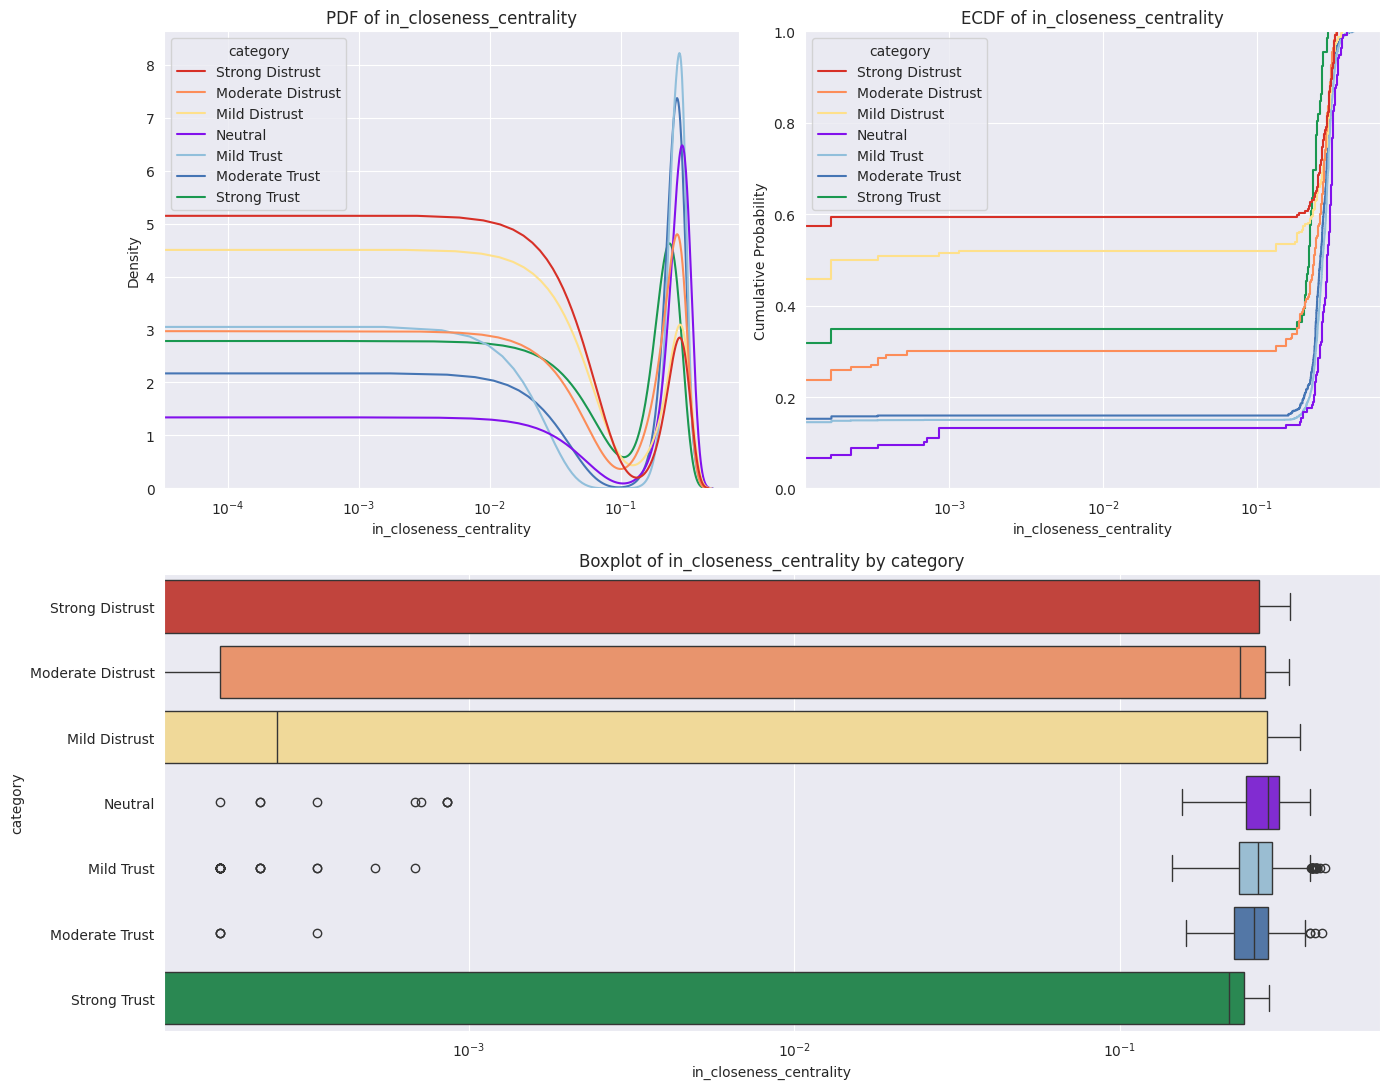

In [62]:
render_eda_plots(metrics_df, "in_closeness_centrality", category_colors=category_color, log_scale=True)


In [129]:
summarize_centrality(metrics_df,"in_closeness_centrality_normalized")

total_in_closeness_centrality_normalized  count  \
category                                                             
Neutral                                            0.026618    137   
Mild Trust                                         0.782042   4309   
Moderate Trust                                     0.098118    564   
Moderate Distrust                                  0.037574    270   
Strong Trust                                       0.007872     66   
Mild Distrust                                      0.026018    258   
Strong Distrust                                    0.021759    249   

                   avg_in_closeness_centrality_normalized_per_node  \
category                                                             
Neutral                                                   0.000194   
Mild Trust                                                0.000181   
Moderate Trust                                            0.000174   
Moderate Distrust                                         0.000139   
Strong Trust                                              0.000119   
Mild Distrust                                             0.000101   
Strong Distrust                                           0.000087   

                   median_in_closeness_centrality_normalized  \
category                                                       
Neutral                                         2.216662e-04   
Mild Trust                                      2.064470e-04   
Moderate Trust                                  2.000324e-04   
Moderate Distrust                               1.819303e-04   
Strong Trust                                    1.676528e-04   
Mild Distrust                                   1.982215e-07   
Strong Distrust                                 0.000000e+00   

                   iqr_in_closeness_centrality_normalized  
category                                                   
Neutral                                          0.000050  
Mild Trust                                       0.000047  
Moderate Trust                                   0.000047  
Moderate Distrust                                0.000217  
Strong Trust                                     0.000187  
Mild Distrust                                    0.000220  
Strong Distrust                                  0.000207

The plots show that while all categories overlap heavily, there are clear shifts in how reachable different groups are. The PDF highlights that Neutral and Trust categories peak at higher values, while Distrust categories peak lower, meaning Neutral and trusted users tend to be more accessible within the network. The ECDF supports this, as Distrust categories accumulate faster at lower values, while Neutral, Mild Trust, and Moderate Trust climb later at higher values, reflecting stronger reachability.

The boxplots confirm this pattern. Neutral users have the highest median closeness overall, followed closely by Mild and Moderate Trust. Moderate Distrust and Strong Trust sit somewhat lower, while Mild and Strong Distrust show the weakest positions, with very low medians and wider variability.

In practice, this means that Neutral and positively trusted users are easier to reach in the Bitcoin OTC network, which makes them more visible and accessible in trading interactions. Distrusted users, by contrast, are harder to reach and sit further from the core of the network. Although there is still overlap across groups, the consistent shift across the plots shows that reputation is tied to accessibility: Neutral and positive reputations correspond to higher reachability, while negative reputations correspond to lower reachability.

### Page Rank

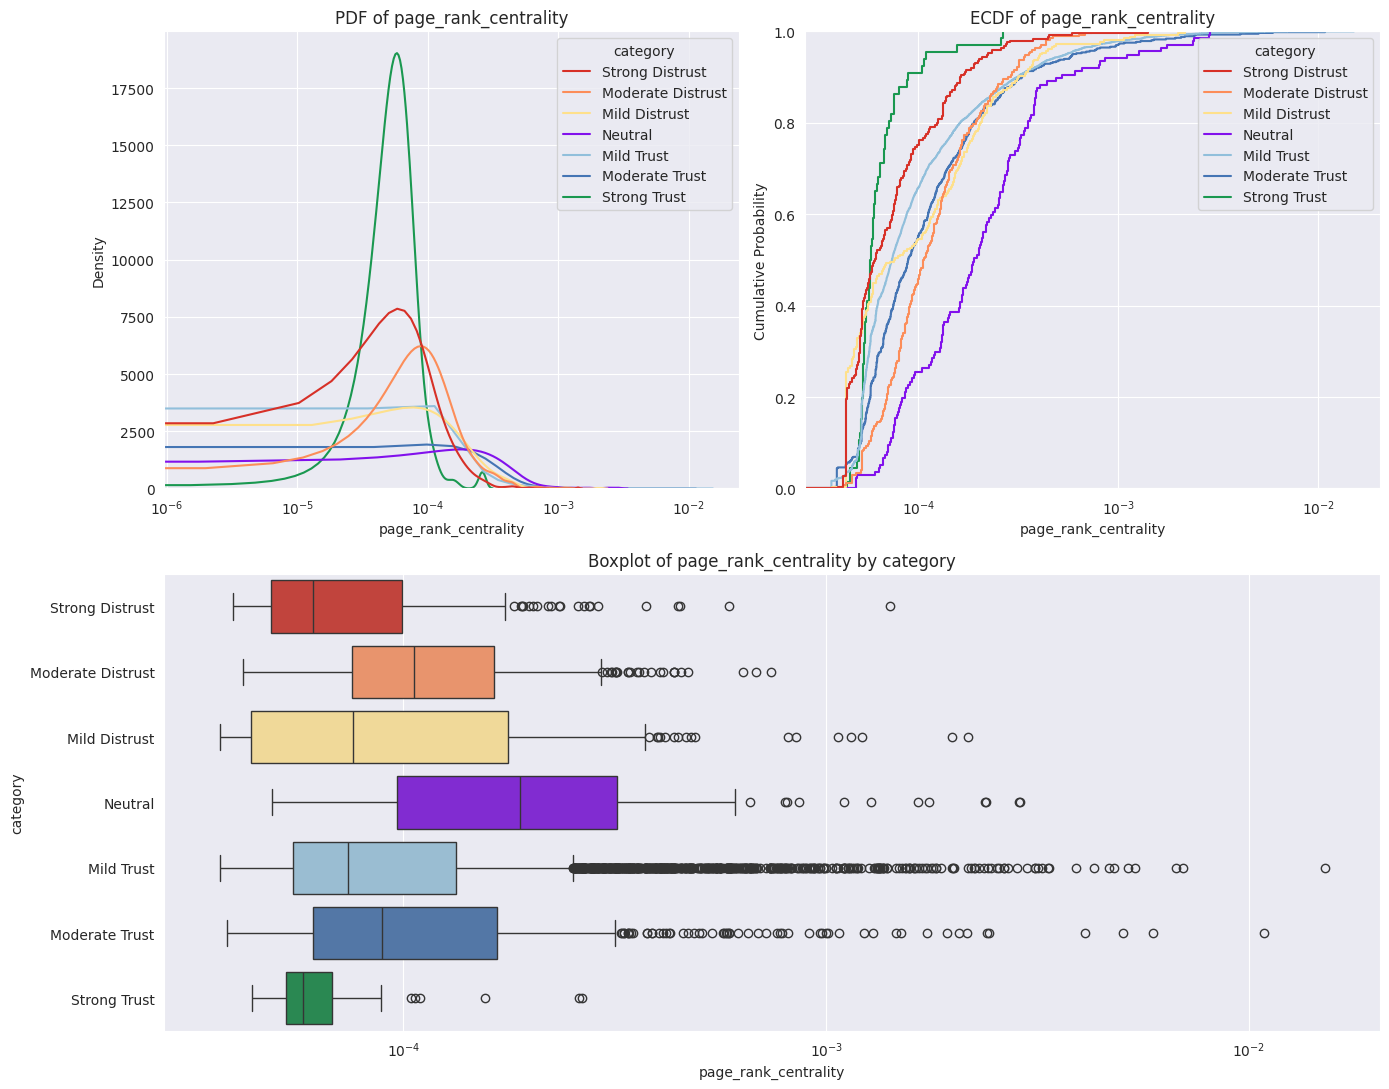

In [63]:
render_eda_plots(metrics_df, "page_rank_centrality", category_colors=category_color, log_scale=True)


In [64]:
summarize_centrality(metrics_df,"page_rank_centrality")

total_page_rank_centrality  count  \
category                                               
Neutral                              0.044191    137   
Moderate Trust                       0.121858    564   
Mild Trust                           0.727589   4309   
Mild Distrust                        0.040249    258   
Moderate Distrust                    0.038248    270   
Strong Distrust                      0.023307    249   
Strong Trust                         0.004558     66   

                   avg_page_rank_centrality_per_node  \
category                                               
Neutral                                     0.000323   
Moderate Trust                              0.000216   
Mild Trust                                  0.000169   
Mild Distrust                               0.000156   
Moderate Distrust                           0.000142   
Strong Distrust                             0.000094   
Strong Trust                                0.000069   

                   median_page_rank_centrality  iqr_page_rank_centrality  
category                                                                  
Neutral                               0.000189                  0.000223  
Moderate Trust                        0.000089                  0.000105  
Mild Trust                            0.000074                  0.000079  
Mild Distrust                         0.000076                  0.000133  
Moderate Distrust                     0.000106                  0.000088  
Strong Distrust                       0.000061                  0.000050  
Strong Trust                          0.000058                  0.000015

The PageRank results show that influence in the network is strongest at the middle of the trust spectrum. On a per-node basis, Mild Trust and Moderate Trust users hold the highest average values, closely followed by Moderate Distrust. These groups also have higher medians and meaningful interquartile ranges, which indicates that a typical user in these categories is well connected to influential neighbors. Mild Distrust and Neutral perform moderately, while Strong Trust and Strong Distrust sit at the bottom, with very low averages and medians that suggest little structural visibility. This confirms that extremes in either direction are not where influence is concentrated.

Looking at the aggregate totals, however, a different picture emerges. Mild Trust dominates the network’s overall PageRank mass, not because each node is exceptionally influential, but because the category is so large. Moderate Trust is the next most important group in total influence, outweighing all of the distrust categories combined. Moderate Distrust, despite showing strong per-node influence, remains modest in aggregate due to its smaller size. Neutral and Mild Distrust contribute relatively little overall, and Strong Trust and Strong Distrust have almost no impact at the network level. Taken together, this shows that the backbone of network visibility is built around Mild and Moderate Trust, while Moderate Distrust plays an outsized role on a per-node basis but cannot shift the total balance.

### Eigenvector Centrality

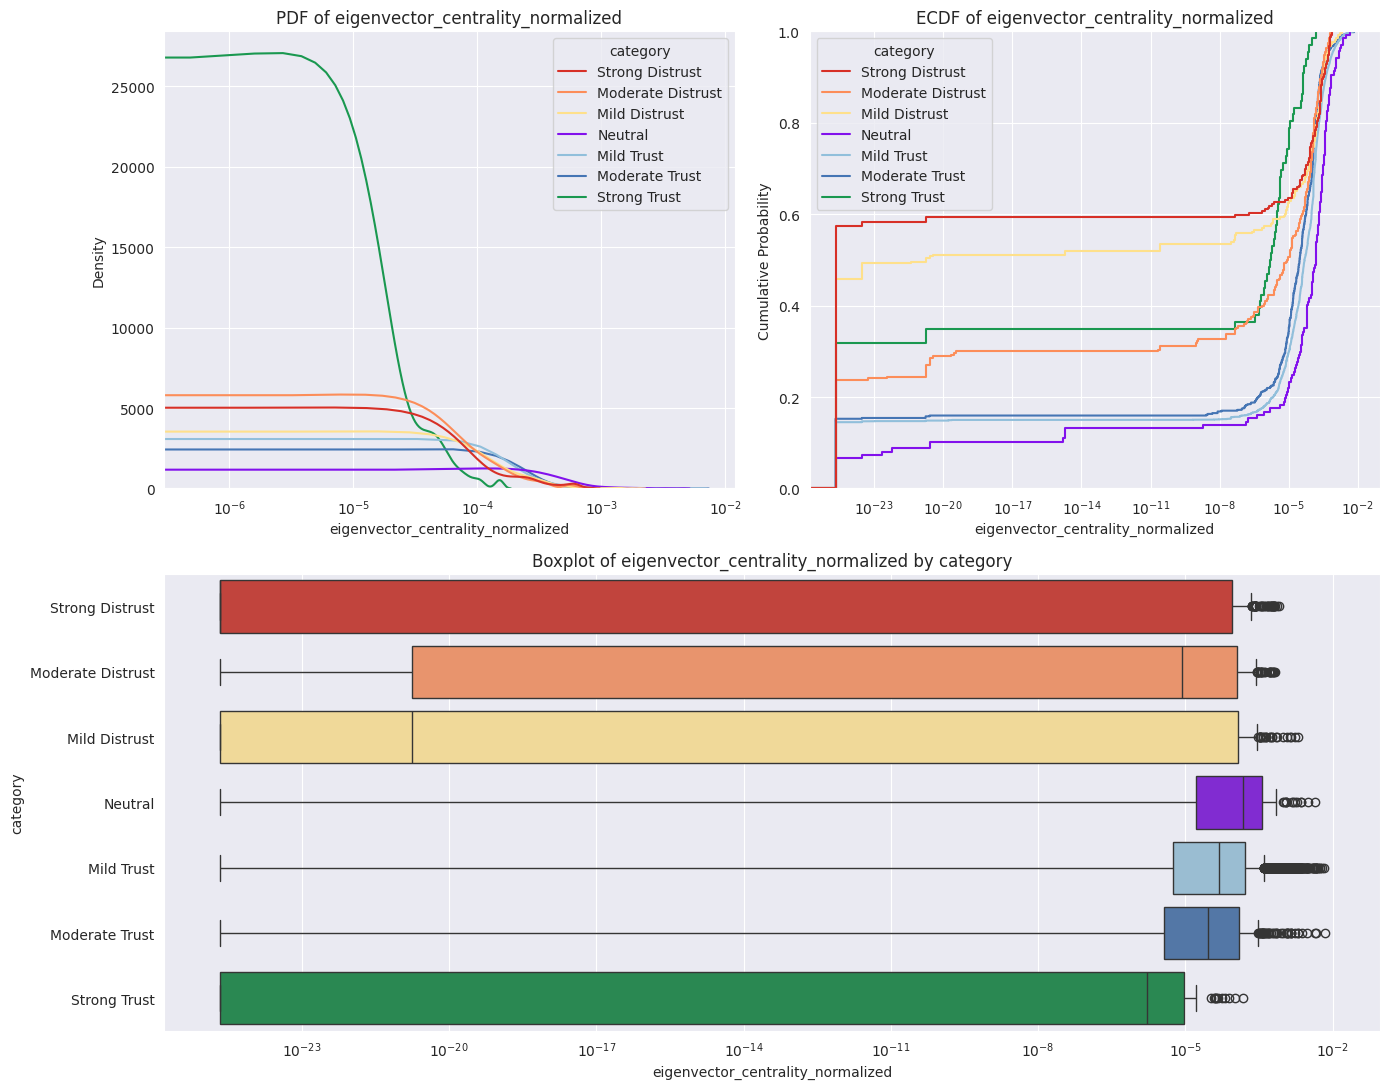

In [65]:
render_eda_plots(metrics_df, "eigenvector_centrality_normalized", category_colors=category_color, log_scale=True)


In [66]:
summarize_centrality(metrics_df,"eigenvector_centrality_normalized")


total_eigenvector_centrality_normalized  count  \
category                                                            
Neutral                                           0.045962    137   
Mild Trust                                        0.801224   4309   
Moderate Trust                                    0.080592    564   
Mild Distrust                                     0.027189    258   
Strong Distrust                                   0.022577    249   
Moderate Distrust                                 0.021612    270   
Strong Trust                                      0.000844     66   

                   avg_eigenvector_centrality_normalized_per_node  \
category                                                            
Neutral                                                  0.000335   
Mild Trust                                               0.000186   
Moderate Trust                                           0.000143   
Mild Distrust                                            0.000105   
Strong Distrust                                          0.000091   
Moderate Distrust                                        0.000080   
Strong Trust                                             0.000013   

                   median_eigenvector_centrality_normalized  \
category                                                      
Neutral                                        1.508489e-04   
Mild Trust                                     4.868150e-05   
Moderate Trust                                 2.964720e-05   
Mild Distrust                                  1.706463e-21   
Strong Distrust                                2.083085e-25   
Moderate Distrust                              8.651288e-06   
Strong Trust                                   1.640893e-06   

                   iqr_eigenvector_centrality_normalized  
category                                                  
Neutral                                         0.000351  
Mild Trust                                      0.000157  
Moderate Trust                                  0.000119  
Mild Distrust                                   0.000119  
Strong Distrust                                 0.000089  
Moderate Distrust                               0.000113  
Strong Trust                                    0.000010

The eigenvector centrality results show that the most structurally influential users are not those at the extremes of trust or distrust, but those in the middle categories. Neutral users stand out most clearly, with the highest median values and the widest spread, meaning they are both consistently central and include some of the most connected individuals in the network. Mild Trust and Moderate Trust also score higher than the rest, suggesting that balanced or moderate reputations embed users more firmly into the influential core, where they connect to other well-positioned actors.

Distrust tells a different story. All three distrust categories have near-zero medians, with only a small minority of nodes achieving noticeable influence. Their wider spreads reflect these exceptions, but most remain marginal. Strong Trust is even weaker, showing virtually no influence at all. Taken together, this means the influential backbone of the network is shaped primarily by Neutral and moderately trusted users, while extremes of both trust and distrust are peripheral, producing isolated outliers rather than consistent structural importance.

## 4. Statistical Evaluation of Network Measures

This section presents the statistical evaluation of network measures to understand how reputation categories relate to user positions in the Bitcoin OTC network. The analysis includes tests of group differences using the Kruskal–Wallis method, an examination of correlations between centrality metrics, and an assessment of assortativity to explore how users connect across reputation categories.

In [ ]:
excluded_fields =    ["node","category","in_degree_centrality_normalized",'out_degree_centrality_normalized', 'betweeness_centrality_normalized', 'closeness_centrality_normalized', 'in_closeness_centrality_normalized', 'eigenvector_centrality_normalized']

    
kruskal_report_m =  list(filter(lambda m: m not in excluded_fields,metrics_df.columns))


### 4.1 Kruskal–Wallis

In [136]:

def label_effect(f):
    if f < 0.10:
        return "negligible"
    elif f < 0.25:
        return "small"
    elif f < 0.40:
        return "medium"
    else:
        return "large"

def eta_squared_kw(H, n, k):
    """Eta-squared effect size for Kruskal–Wallis."""
    return max(0.0, (H - k + 1) / (n - k))

def epsilon_squared_kw(H, n, k):
    """Epsilon-squared effect size for Kruskal–Wallis."""
    return max(0.0, (H - k) / (n - 1))

def run_kruskal_test(df: pd.DataFrame, metric: str, group_col: str = "category"):
    groups = [sub_df[metric].values for _, sub_df in df.groupby(group_col)]
    
    # Run Kruskal–Wallis
    stat, p = kruskal(*groups)
    
    result = {
        "metric": metric,
        "H_statistic": stat,
        "p_value": p,
        "significant": p < 0.05
    }
    return result

# Example usage
kr_rows = []

for metric in kruskal_report_m:
    kr_rows.append(run_kruskal_test(metrics_df, metric))


n = len(metrics_df)
k = metrics_df['category'].nunique()

kruskal_df = pd.DataFrame(kr_rows)

kruskal_df["eta2_kw"] = kruskal_df["H_statistic"].apply(lambda H: eta_squared_kw(H, n, k))
kruskal_df["eps2_kw"] = kruskal_df["H_statistic"].apply(lambda H: epsilon_squared_kw(H, n, k))
kruskal_df["cohen_f"] = np.sqrt(kruskal_df["eta2_kw"] / (1 - kruskal_df["eta2_kw"]))
kruskal_df["effect_size_label"] = kruskal_df["cohen_f"].apply(label_effect)


In [137]:
kruskal_df

metric  H_statistic       p_value  significant  \
0             in_degree_centrality   297.486148  2.827395e-61         True   
1            out_degree_centrality   226.693699  3.886335e-46         True   
2            betweeness_centrality   172.434201  1.369681e-34         True   
3             closeness_centrality   206.291459  8.683040e-42         True   
4           eigenvector_centrality   283.841875  2.364302e-58         True   
5             page_rank_centrality   248.353705  9.219851e-51         True   
6          in_closeness_centrality   326.136867  2.038522e-67         True   
7  in_degree_centrality_normalized   297.486148  2.827395e-61         True   

    eta2_kw   eps2_kw   cohen_f effect_size_label  
0  0.049861  0.049639  0.229079             small  
1  0.037751  0.037542  0.198071             small  
2  0.028470  0.028270  0.171184             small  
3  0.034261  0.034055  0.188353             small  
4  0.047527  0.047307  0.223379             small  
5  0.041456  0.041243  0.207965             small  
6  0.054762  0.054535  0.240695             small  
7  0.049861  0.049639  0.229079             small

I used the Kruskal–Wallis test to check whether centrality scores differ across the reputation categories in the Bitcoin OTC network. All of the tests came back highly significant, with p-values close to zero. This means that a user’s reputation category is strongly related to their position in the network.

Looking at effect sizes gives us a sense of how big these differences are. In-degree centrality shows the strongest effect, with a medium size (Cohen’s f = 0.26). This means that how often a user receives ratings varies quite a lot depending on their reputation group. In other words, being trusted or distrusted makes a real difference in how visible a user is. Measures like out-degree (how often users give ratings) and betweenness (acting as a go-between for others) show smaller effects, meaning reputation affects these behaviors but not as strongly. The other measures such as closeness, in-closeness, PageRank, and eigenvector centrality also show small effects, which suggests that reputation has only a modest influence on accessibility and influence in the network.

Overall, the results show that the number of ratings a user receives (in-degree) is the clearest signal of reputation differences. Other measures also capture differences between groups, but the effects are smaller and less pronounced.

### 4.2 Correlation Matrix of centrality Metrics

In [70]:
from itertools import combinations

corr_results = []

# only unique unordered pairs
for m1, m2 in combinations(kruskal_report_m, 2):
    rho, p = spearmanr(metrics_df[m1], metrics_df[m2], nan_policy="omit")
    corr_results.append({
        "metric1": m1,
        "metric2": m2,
        "rho": rho,
        "p_value": p
    })

corr_df = pd.DataFrame(corr_results)
# corr_df.sort_values("rho", ascending=False)

In [71]:
corr_matrix = metrics_df[kruskal_report_m].corr(method="spearman")
corr_matrix

in_degree_centrality  \
in_degree_centrality                           1.000000   
out_degree_centrality                          0.825395   
betweeness_centrality                          0.865813   
closeness_centrality                           0.655674   
page_rank_centrality                           0.902190   
in_closeness_centrality                        0.624657   
eigenvector_centrality_normalized              0.637755   

                                   out_degree_centrality  \
in_degree_centrality                            0.825395   
out_degree_centrality                           1.000000   
betweeness_centrality                           0.884357   
closeness_centrality                            0.547877   
page_rank_centrality                            0.819802   
in_closeness_centrality                         0.823183   
eigenvector_centrality_normalized               0.833057   

                                   betweeness_centrality  \
in_degree_centrality                            0.865813   
out_degree_centrality                           0.884357   
betweeness_centrality                           1.000000   
closeness_centrality                            0.561895   
page_rank_centrality                            0.829043   
in_closeness_centrality                         0.665120   
eigenvector_centrality_normalized               0.667593   

                                   closeness_centrality  page_rank_centrality  \
in_degree_centrality                           0.655674              0.902190   
out_degree_centrality                          0.547877              0.819802   
betweeness_centrality                          0.561895              0.829043   
closeness_centrality                           1.000000              0.498666   
page_rank_centrality                           0.498666              1.000000   
in_closeness_centrality                        0.704406              0.566822   
eigenvector_centrality_normalized              0.702867              0.578146   

                                   in_closeness_centrality  \
in_degree_centrality                              0.624657   
out_degree_centrality                             0.823183   
betweeness_centrality                             0.665120   
closeness_centrality                              0.704406   
page_rank_centrality                              0.566822   
in_closeness_centrality                           1.000000   
eigenvector_centrality_normalized                 0.989354   

                                   eigenvector_centrality_normalized  
in_degree_centrality                                        0.637755  
out_degree_centrality                                       0.833057  
betweeness_centrality                                       0.667593  
closeness_centrality                                        0.702867  
page_rank_centrality                                        0.578146  
in_closeness_centrality                                     0.989354  
eigenvector_centrality_normalized                           1.000000

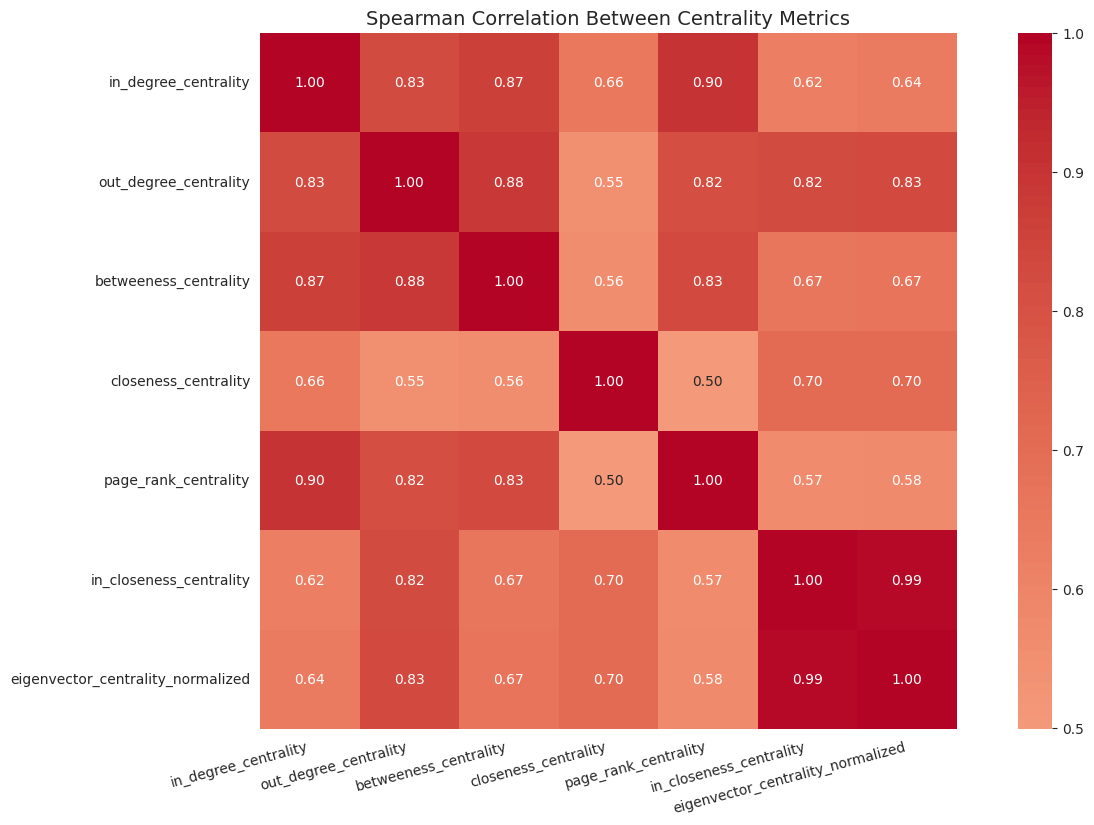

In [72]:


plt.figure(figsize=(14, 10))
sea.heatmap(
    corr_matrix, 
    annot=True,       
    fmt=".2f",       
    cmap="coolwarm",   
    center=0,         
    square=True
)
plt.title("Spearman Correlation Between Centrality Metrics", fontsize=14)
plt.tight_layout()
plt.xticks(rotation=15, ha="right", fontsize=10)
plt.show()


The correlation results show that several centrality measures are strongly related. In-degree, out-degree, betweenness, and PageRank move closely together, indicating that users who receive many ratings are also more active in giving ratings, often sit on paths connecting others, and rank highly in PageRank. In-closeness and eigenvector centrality also show an almost perfect relationship, reflecting that users who are easy to reach in the network are often the same users connected to other influential actors. In contrast, closeness centrality is less strongly tied to the other measures, capturing a different aspect of network position by focusing on how quickly a user can reach others.

### 4.3 Assortativity

In [73]:
assortativity = nx.attribute_assortativity_coefficient(btcTrustGraph, "category")
print("Category assortativity:", assortativity)

Category assortativity: 0.11691432261137268


The category assortativity score for the Bitcoin OTC network is 0.117, which is positive but relatively low. This indicates a weak tendency for users to interact with others who share the same reputation category. In practical terms, trusted users show some preference for rating other trusted users, and distrusted users also cluster together, but the pattern is not strong enough to suggest clear separation. Instead, there is still considerable cross-category interaction, reflecting the mixed nature of trading relationships where users sometimes connect across trust boundaries despite a mild pull toward their own group.

# 5. Conclusion


Looking at both the plots and the statistical tests gives us a clearer picture of how reputation shapes network position. Each metric highlights something a little different:  

- **In-degree centrality (ratings received):** Distrusted and Neutral users usually get more ratings than Trusted ones, so they appear more visible.  
- **Out-degree centrality (ratings given):** Neutral, Mild Trust, and Moderate Trust users are the most active in rating others, while Strong Trust users almost never do.  
- **Betweenness centrality (bridging roles):** Neutral, Moderate Trust, and Moderate Distrust users are the ones most often linking different parts of the network.  
- **Closeness centrality (reaching others):** Neutral and Distrusted raters can reach others faster, while Trusted raters are generally less direct.  
- **In-closeness centrality (being reached by others):** Trusted users are easier to reach, while Distrusted ones sit further out.  
- **PageRank and Eigenvector centrality (influence):** Users with Mild or Moderate Trust, and sometimes Neutral ones, tend to be the most structurally important. Strong Trust and Strong Distrust sit at the edges with little impact.  

From these plots, it’s clear that reputation doesn’t automatically mean influence or visibility. In fact, users in the middle of the spectrum, and sometimes even those with negative reputations, often hold key positions.  

The tests backed this up but added nuance. The **Kruskal–Wallis results** showed that the differences between groups are real and not random. Still, the **effect sizes** told us most of these differences are small, with in-degree centrality standing out as the strongest. The **correlations** showed a lot of overlap between measures, which explains why the same groups keep showing up across metrics. And the **assortativity test** suggested that while people lean a little toward connecting with those in the same reputation group, there’s still a lot of mixing across categories.  

All together, the evidence shows that being highly trusted doesn’t guarantee centrality in the Bitcoin OTC network. Instead, visibility and influence are more often held by Neutral, Mild Trust, and Moderate Trust users, with Distrusted groups also playing key roles at times. Strong Trust and Strong Distrust users tend to stay more on the margins. In short, the real drivers of interaction and influence are those in the middle ground, not at the extremes.  
